## Gabriel ROMON and Ulrich GOUE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
def load_data(kind='data'):
    filename = '.\classification_data_HWK2\EMGaussian.%s'%kind
    df = pd.read_csv(filename, sep=' ', names = ['X1', 'X2'])
    n = df.shape[0]

    X = df.values
    return X

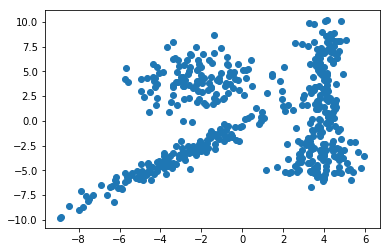

In [4]:
X = load_data()
X_test = load_data('test')
plt.scatter(X[:,0], X[:,1])

In [5]:
class Kmeans():
    
    def __init__(self, n_clusters=4):
        """
        Initialization with the number of clusters
        """
        self.K = n_clusters
        
    def l2_dist(self, sample):
        """ 
        Compute the distance between a given sample and the current centroids
        """
        dists =  np.sqrt(np.sum((self.centers - sample)**2, axis=1))
        return dists
    
    def classify(self, sample):
        """
        Classify a given sample to its closest cluster
        """
        dists = self.l2_dist(sample)
        return np.argmin(dists)
    
    def fit(self, samples, seed=None, max_iters=20, verbose=False):
        """
        Fits the K-means Clustering to a given dataset
        """
        if seed is not None:
            np.random.seed(seed)
        
        n_samples = samples.shape[0]
        # We initialize centers by randomly choose among the samples
        #possibilities = [i for i in range(n_samples)]
        #choices = np.random.choice(possibilities, self.K)
        #self.centers = samples[choices]
        
        self.centers = 2*samples.std()*(np.random.random(size=(self.K, samples.shape[1]))-0.5)
        self.initial_centers = np.copy(self.centers)
        self.loss = 0
        
        # We loop until stability
        old_assigns = None
        self.n_iters = 0
        
        for i in range(max_iters):
            new_assigns = [self.classify(sample) for sample in samples]
            
            if new_assigns == old_assigns:
                if verbose: print("Convergence reached after %i iterations"%self.n_iters)
                break
            
            old_assigns = new_assigns
            self.n_iters += 1
            
            #Update centers
            for index in range(self.K):
                samples_index = np.where(np.array(new_assigns)==index)
                sample_points = samples[samples_index]
                self.centers[index] = sample_points.mean(axis=0)
        #update loss
        dists = np.array([self.l2_dist(sample).tolist() for sample in samples])
        dists[np.where(np.isnan(dists))] = np.inf
        self.loss = dists.min(axis=1).sum()

        
            
    def predict(self, X):
        return np.array([self.classify(sample) for sample in X])
    
    #def

In [6]:
losses = []
trials = 150
np.random.seed(123)
seeds = np.random.randint(1500, size=trials).tolist()
centers = []

for i,seed in enumerate(seeds):

    clf = Kmeans()
    clf.fit(X, max_iters=5, seed=seed)
    y = clf.predict(X)
    loss= clf.loss
    losses.append(loss)
    centers.append(clf.centers)

(array([92.,  6.,  6.,  3.,  4.,  8.,  7.,  1., 17.,  2.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  3.]),
 array([1101.41186256, 1124.53756743, 1147.6632723 , 1170.78897716,
        1193.91468203, 1217.0403869 , 1240.16609177, 1263.29179664,
        1286.41750151, 1309.54320638, 1332.66891125, 1355.79461612,
        1378.92032099, 1402.04602585, 1425.17173072, 1448.29743559,
        1471.42314046, 1494.54884533, 1517.6745502 , 1540.80025507,
        1563.92595994]),
 <a list of 20 Patch objects>)

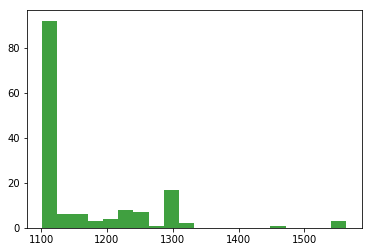

In [7]:
plt.hist(losses, 20, density=False, facecolor='g', alpha=0.75)

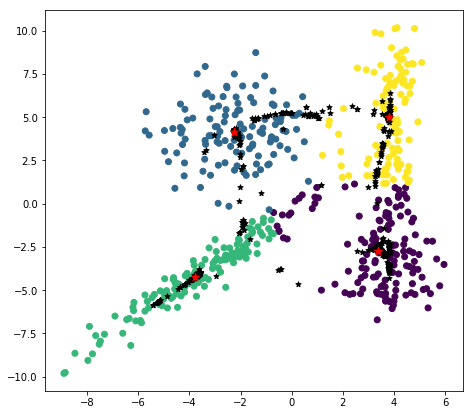

In [8]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7.5, 7)
plt.scatter(X[:,0], X[:,1], c=y)
for c in centers:
    ax.scatter(c.T[0,:],c.T[1,:],c='k', s=30, marker='*') 
ax.scatter(clf.centers.T[0,:],clf.centers.T[1,:],c='r', s=70, marker='*')

## EM-ALGORITHM For Gaussian Mxiture Model (GMM)

In [9]:
from numpy.linalg import slogdet, solve
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
from numpy.testing import assert_allclose

In [10]:
def log_gaussian_pdf(x_i, mu_c, sigma_c):
    """
    Computes log N(x_i | mu_c, sigma_c)
    """
    n = len(mu_c)
    a = n * np.log(2 * np.pi)
    _, b = slogdet(sigma_c)
    
    y = np.linalg.solve(sigma_c, x_i - mu_c)
    c = np.dot(x_i - mu_c, y)
    return -0.5 * (a + b + c)

def plot_countour(X, x, y, z, ax, xlim, ylim):
    def fixed_aspect_ratio(ratio, ax):
        '''
        Set a fixed aspect ratio on matplotlib plots 
        regardless of axis units
        '''
        xvals, yvals = ax.get_xlim(), ax.get_ylim()

        xrange = xvals[1] - xvals[0]
        yrange = yvals[1] - yvals[0]
        ax.set_aspect(ratio* (xrange / yrange), adjustable='box')
        
    # contour the gridded data, plotting dots at the randomly spaced data points.
    ax.contour(x, y, z, 6, linewidths=0.5, colors='k')
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    fixed_aspect_ratio(1, ax)
    return ax

In [11]:
class GMM():
    
    def __init__(self, X, K=4):
        self.X = X
        self.K = K
        self.N = X.shape[0]
        self.d = X.shape[1]
        
    def params_init(self, isotropic=False):
        K = self.K
        d = self.d
        
        rr = np.random.rand(K)
        self.pi = rr/rr.sum()
        self.Q = np.zeros((self.N, K))
        
        clf = Kmeans(K)
        clf.fit(self.X, seed=1234, verbose=False)
        self.mu = clf.centers
        self.sigma = np.array([np.identity(d) for _ in range(K)])
        if isotropic:
            self.lambda_ = np.array([1. for _ in range(K)])

    def likelihood_lower_bound(self, X):
        N = self.N 
        K = self.K 
        d = self.d 

        expec1, expec2 = 0., 0.
        for i in range(N):
            x_i = X[i]

            for c in range(K):
                pi_k = self.pi[c]
                z_nk = self.Q[i, c]
                mu_k = self.mu[c, :]
                sigma_k = self.sigma[c, :, :]
                
                log_pi_k = np.log(pi_k)
                log_p_x_i = log_gaussian_pdf(x_i, mu_k, sigma_k)
                prob = z_nk * (log_p_x_i + log_pi_k)
                
                expec1 += prob
                expec2 += z_nk * np.log(z_nk)

        loss = expec1 - expec2
        return loss
    
    def likelihood_lower_bound_(self, X):
        N = self.N 
        K = self.K 
        d = self.d 

        expec1, expec2 = 0., 0.
        for i in range(N):
            x_i = X[i]
            dens = np.array([self.pi[c]*np.exp(log_gaussian_pdf(x_i, self.mu[c,:], self.sigma[c,:,:])) for c in range(K)])
            Q = dens / dens.sum()
            for c in range(K):
                pi_k = self.pi[c]
                z_nk = Q[c]
                mu_k = self.mu[c, :]
                sigma_k = self.sigma[c, :, :]
                
                log_pi_k = np.log(pi_k)
                log_p_x_i = log_gaussian_pdf(x_i, mu_k, sigma_k)
                prob = z_nk * (log_p_x_i + log_pi_k)
                
                expec1 += prob
                expec2 += z_nk * np.log(z_nk)

        loss = expec1 - expec2
        return loss
    
    def _E_step(self, X):
        for i in range(self.N):
            x_i = X[i, :]

            denom_vals = [] 
            for c in range(self.K):
                pi_c = self.pi[c]
                mu_c = self.mu[c, :]
                sigma_c = self.sigma[c, :, :]
                
                log_pi_c = np.log(pi_c)
                log_p_x_i = log_gaussian_pdf(x_i, mu_c, sigma_c)
                denom_vals.append(log_p_x_i + log_pi_c) 

            log_denom = logsumexp(denom_vals) 
            q_i = np.exp([num - log_denom for num in denom_vals])
            assert_allclose(np.sum(q_i), 1, err_msg='{}'.format(np.sum(q_i)))
            
            self.Q[i, :] = q_i

    def _M_step(self, X, isotropic=False):
        K, d, N = self.K, self.d, self.N
        mu =  self.mu
 
        denoms = np.sum(self.Q, axis=0)
        
        # update cluster priors
        self.pi = denoms / N

        # update cluster means
        nums_mu = [np.dot(self.Q[:, c], X) for c in range(K)] 
        for ix, (num, den) in enumerate(zip(nums_mu, denoms)):
            self.mu[ix, :] = num / den
        
        # update cluster covariances
        X, mu = self.X, self.mu
        for c in range(K):
            mu_c = self.mu[c, :]
            n_c = denoms[c]

            outer = np.zeros((d, d))
            lambda_ = 0.
            for i in range(N):
                wic = self.Q[i, c]
                xi = self.X[i, :]
                if not isotropic:
                    outer += wic * np.outer(xi - mu_c, xi - mu_c)
                else:
                    lambda_ += wic * np.dot(xi - mu_c, xi - mu_c) 

            if not isotropic:
                outer /= n_c
                self.sigma[c, :, :] = outer
            else:
                outer = lambda_ * np.identity(d)
                self.sigma[c, :, :] = outer / (n_c * d)
                self.lambda_[c] = lambda_ / (n_c * d)
    
        assert_allclose(np.sum(self.pi), 1, err_msg='{}'.format(np.sum(self.pi)))
        
    def fit(self, max_iter=75, rtol=1e-3, verbose=False, isotropic=False):
        self.params_init(isotropic=isotropic)
        prev_vlb = -np.inf
        
        for _iter in range(max_iter):
            try:
                self._E_step(self.X)             
                self._M_step(self.X, isotropic=isotropic)               
                vlb = self.likelihood_lower_bound(self.X)

                if verbose:
                    print('{}. Lower bound: {}'.format(_iter + 1, vlb))

                if np.abs((vlb - prev_vlb) / prev_vlb) <= rtol or np.isnan(vlb):
                    break

                prev_vlb = vlb
            
            except np.linalg.LinAlgError:
                print("Singular matrix: components collapsed")
                pass
            
    def predict(self):
        return G.Q.argmax(axis=1)
    
    def plot_clusters(self, title):
        K = self.K

        xmin, xmax = (self.X[:,0].min()-1.5, self.X[:,0].max()+2)
        ymin, ymax = (self.X[:,1].min()-1.5, self.X[:,1].max()+1.5)

        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(7.5, 9)

        for c in range(K):
            rv = multivariate_normal(self.mu[c], self.sigma[c])

            x = np.linspace(xmin, xmax, 500)
            y = np.linspace(ymin, ymax, 500)

            X1, Y1 = np.meshgrid(x, y)
            xy = np.column_stack([X1.flat, Y1.flat])

            # density values at the grid points
            Z = rv.pdf(xy).reshape(X1.shape)
            ax = plot_countour(X, X1, Y1, Z, ax=ax, xlim=(xmin, xmax), ylim=(ymin, ymax))
            ax.plot(self.mu[c, 0], self.mu[c, 1], 'ro')
            
        # plot data points
        labels = self.Q.argmax(1)
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=30) 
        plt.title(title)
        plt.show()

In [12]:
G = GMM(X, K=4)
G.fit(max_iter=75, verbose=False, isotropic=True)
y = G.predict()
#plt.scatter(X[:,0], X[:,1], c=y)

C:\Users\utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in double_scalars


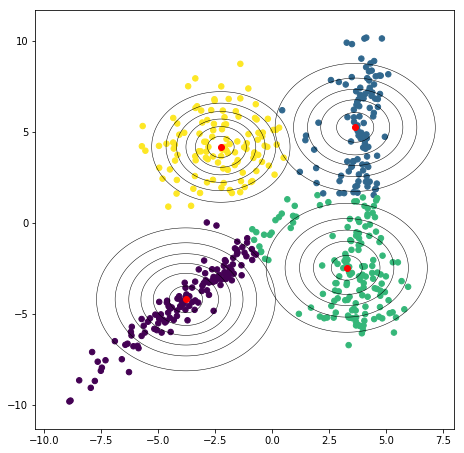

In [13]:
G.plot_clusters('')

In [14]:
print('the likelihood for the training dataset is: ',G.likelihood_lower_bound(X))

print('the likelihood for the test dataset is: ', G.likelihood_lower_bound_(X_test))

the likelihood for the training dataset is:  -2653.230658182921
the likelihood for the test dataset is:  -2656.540801904987


In [15]:
H = GMM(X, K=4)
H.fit(max_iter=75, verbose=False, isotropic=False)
y = H.Q.argmax(axis=1)
#plt.scatter(X[:,0], X[:,1], c=y)

C:\Users\utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in double_scalars


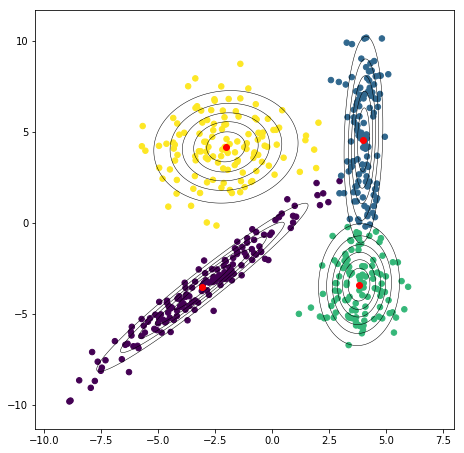

In [16]:
H.plot_clusters('')

In [17]:
print('the likelihood for the training dataset is: ',H.likelihood_lower_bound(X))

print('the likelihood for the testing dataset is: ', H.likelihood_lower_bound_(X_test))

the likelihood for the training dataset is:  -2331.248843372363
the likelihood for the testing dataset is:  -2418.9545623290983
